In [2]:
import scipy
from scipy import io
from glob import glob
from scipy import misc
import imageio
import numpy as np
import pandas as pd
from skimage import transform,io
import os
import random
import memory_profiler
from datetime import datetime
from sklearn.decomposition import PCA
%load_ext memory_profiler

In [2]:
os.chdir('./')
os.getcwd()

'C:\\Users\\lucy\\Desktop\\proj3'

In [3]:
from sys import platform
if platform == "darwin":
   dataset_name = 'images'
   path = glob('../data/train_set/%s/*' % (dataset_name))
   train_dir = "../data/train_set/" # This will be modified for different data sets.
elif platform == "win32":
   dataset_name = 'images'
   path = glob('./data/train_set/%s/*' % (dataset_name))
   train_dir = "./data/train_set/" # This will be modified for different data sets.

### Step 0 set work directories, extract paths, summarize

Provide directories for training images. Training images and Training fiducial points will be in different subfolders. 

In [4]:
train_image_dir = train_dir + "images/"
train_pt_dir = train_dir + "points/"
train_label_path = train_dir +"label.csv"

### Step 1: set up controls for evaluation experiments.

In this chunk, we have a set of controls for the evaluation experiments. 

+ (T/F) cross-validation on the training set
+ (number) K, the number of CV folds
+ (T/F) process features for training set
+ (T/F) run evaluation on an independent test set
+ (T/F) process features for test set


In [5]:
run_cv=True # run cross-validation on the training set
K = 5  # number of CV folds
run_feature_train=True # process features for training set
run_test=True # run evaluation on an independent test set
run_feature_test=True # process features for test set

Using cross-validation or independent test set evaluation, we compare the performance of models with different specifications.

### Step 2: import data and train-test split 

In [6]:
#train-test split

info = pd.read_csv(train_label_path)
n = len(info)
n_train = round(n*(4/5), 0)
random.seed(1)
train_idx = np.random.choice(info.Index, size=int(n_train), replace=False)
test_idx = list(set(info.Index) - set(train_idx))

If you choose to extract features from images, such as using Gabor filter, R memory will exhaust all images are read together. The solution is to repeat reading a smaller batch(e.g 100) and process them. 

In [7]:
dataDir = train_pt_dir
fiducial_pt_list = []
filelist = []
for file in os.listdir(dataDir):
    filelist.append(file)
filelist.sort()
for file in filelist:
    fiducial_pt_list.append(scipy.io.loadmat(dataDir+file))

In [8]:
l = []
for i in range(len(fiducial_pt_list)):
    if 'faceCoordinatesUnwarped' in fiducial_pt_list[i].keys():
        l.append(fiducial_pt_list[i]['faceCoordinatesUnwarped'])
    else:
        l.append(fiducial_pt_list[i]['faceCoordinates2'])

In [9]:
fiducial_pt_list = l

In [10]:
import sklearn.metrics.pairwise
def pairwise_dist(vec):
    dist  = sklearn.metrics.pairwise_distances(vec, metric='euclidean')
    np.fill_diagonal(dist, np.nan)
    return dist

def feature(fiducial_pt_list,index,info= pd.read_csv(train_label_path)):
    pairwise_dist_feature = pairwise_dist(fiducial_pt_list[index]).flatten()
    pairwise_dist_feature = pairwise_dist_feature[~np.isnan(pairwise_dist_feature)]
    pairwise_dist_feature = np.append(pairwise_dist_feature,info['emotion_idx'][index])
    #pairwise_data  = cbind(pairwise_dist_feature, info['emotion_idx'][index])
    return pairwise_dist_feature

In [11]:
train_idx_1 = [x-1 for x in train_idx]
test_idx_1 = [x-1 for x in test_idx]

In [12]:
train_idx = [x-1 for x in train_idx]
dat_train = pd.DataFrame(np.zeros((2000, 6007)))
dat_test = pd.DataFrame(np.zeros((500, 6007)))
for i in range(len(train_idx_1)):
    dat_train.iloc[i,:] = np.round(feature(fiducial_pt_list, train_idx_1[i]).flatten(), 0)

for i in range(len(test_idx)):
    dat_test.iloc[i,:] = np.round(feature(fiducial_pt_list, test_idx_1[i]).flatten(), 0)

In [13]:
dat_train = dat_train.astype(int)
dat_test = dat_test.astype(int)
print(dat_train.columns.values)
print(dat_test.shape)

[   0    1    2 ... 6004 6005 6006]
(500, 6007)


In [14]:
#get x,y
train_x = dat_train.drop(6006, axis=1)
test_x  = dat_test.drop(6006, axis=1)
print(train_x.shape)
print(test_x.shape)
print(train_x[0])
print(test_x[0])
train_y = dat_train[6006]
train_y = train_y -1
test_y = dat_test[6006]
test_y = test_y -1
print(train_y)
print(test_y)

(2000, 6006)
(500, 6006)
0       24
1       36
2       35
3       28
4       41
        ..
1995    30
1996    34
1997    48
1998    28
1999    39
Name: 0, Length: 2000, dtype: int32
0      46
1      37
2      38
3      28
4      35
       ..
495    32
496    35
497    36
498    31
499    31
Name: 0, Length: 500, dtype: int32
0        5
1       19
2       16
3       10
4       11
        ..
1995     7
1996    16
1997     9
1998     5
1999     1
Name: 6006, Length: 2000, dtype: int32
0       0
1      18
2       0
3      18
4      18
       ..
495    17
496    17
497    17
498    17
499    17
Name: 6006, Length: 500, dtype: int32


### Step3: Baseline

In [15]:
#gbm baseline
start=datetime.now()
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
%memit
baseline = GradientBoostingClassifier(learning_rate=0.05, n_estimators=22,max_depth=2, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
baseline.fit(train_x,train_y)
%memit
print('fit time:',datetime.now()-start)
start=datetime.now()
predictors=list(train_x)
feat_imp = pd.Series(baseline.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.3f}'.format(baseline.score(test_x, test_y)))
pred=baseline.predict(train_x)
print(classification_report(train_y, pred))
pred=baseline.predict(test_x)
print(classification_report(test_y, pred))
print('predict time',datetime.now()-start)

peak memory: 270.66 MiB, increment: 0.11 MiB
peak memory: 274.60 MiB, increment: 0.00 MiB
fit time: 0:00:13.279444
Accuracy of the GBM on test set: 0.336
              precision    recall  f1-score   support

           0       0.62      0.83      0.71        89
           1       0.70      0.78      0.74       102
           2       0.53      0.73      0.61       108
           3       0.72      0.68      0.70        90
           4       0.75      0.61      0.67        93
           5       0.63      0.67      0.65        79
           6       0.64      0.53      0.58        89
           7       0.75      0.81      0.78        99
           8       0.62      0.65      0.63        88
           9       0.68      0.52      0.59        84
          10       0.73      0.42      0.53        96
          11       0.56      0.70      0.62        93
          12       0.41      0.53      0.46        83
          13       0.63      0.70      0.66       100
          14       0.48      0.59  

### Step4: Other Machine Learning Models

In [16]:
#xgboost
import xgboost
from xgboost import XGBClassifier
xgb = XGBClassifier(
   n_estimators=30,
   min_child_weight = 1,
   gamma = 0,
   subsample = 0.8,
   max_depth=2,
   colsample_bytree = 0.8,
   reg_alpha = 0.005)
xgboost = xgb.fit(train_x,train_y)

start=datetime.now()
xgboost_pred_train = xgboost.predict(train_x)
xgboost_pred_test = xgboost.predict(test_x)
print('predict time:',datetime.now()-start)
xg_train_accuracy = (xgboost_pred_train==train_y).sum()/2000
xg_test_accuracy = (xgboost_pred_test==test_y).sum()/500
print(xg_train_accuracy,xg_test_accuracy)

predict time: 0:00:05.737332
0.726 0.444


In [17]:
#classification report in xgb
from sklearn.metrics import classification_report
print(classification_report(train_y, xgboost_pred_train))
print(classification_report(test_y , xgboost_pred_test))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84        89
           1       0.79      0.91      0.85       102
           2       0.68      0.77      0.72       108
           3       0.77      0.80      0.78        90
           4       0.85      0.84      0.84        93
           5       0.73      0.77      0.75        79
           6       0.78      0.56      0.65        89
           7       0.85      0.84      0.84        99
           8       0.85      0.83      0.84        88
           9       0.71      0.63      0.67        84
          10       0.80      0.61      0.69        96
          11       0.63      0.74      0.68        93
          12       0.66      0.52      0.58        83
          13       0.69      0.84      0.76       100
          14       0.69      0.72      0.71        76
          15       0.73      0.88      0.80        93
          16       0.62      0.77      0.69        95
          17       0.71    

In [18]:
#PCA
pca= PCA(random_state = 42)
pca.fit(train_x)
k=0
total= sum(pca.explained_variance_)
current_sum=0
while current_sum/total < 0.94: #we want the reduced features explain 94% of the original data
    current_sum += pca.explained_variance_[k]
    k+=1
print(k)
pca1=PCA(n_components=k,whiten=True)
train_transform_data= pca1.fit_transform(train_x)
print(train_transform_data.shape)
test_transform_data=pca1.transform(test_x)
print(test_transform_data.shape)

12
(2000, 12)
(500, 12)


In [19]:
#Cross Validation Xgboost
from sklearn.model_selection import GridSearchCV

estimator = XGBClassifier(
   objective='multi:softprob',
   seed=24
)
parameters = {
   'max_depth': range (1, 5, 1),
   'n_estimators': range(1, 200, 20),
   'learning_rate': [0.1, 0.01, 0.05]
}


# Create a classifier object with the classifier and parameter candidates
clf1 = GridSearchCV(estimator=estimator, cv =5, param_grid=parameters, n_jobs=-1)

# Train the classifier on data1's feature and target data
clf1.fit(train_transform_data, train_y)

# View the accuracy score
print('Best score for data:', clf1.best_score_) 

# View the best parameters for the model found using grid search
print('Best Max Depth:',clf1.best_estimator_.max_depth) 
print('Best N.estimators:',clf1.best_estimator_.n_estimators)
print('Best Learning Rate:',clf1.best_estimator_.learning_rate)

C:\Users\lucy\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best score for data: 0.3085
Best Max Depth: 2
Best N.estimators: 181
Best Learning Rate: 0.1


In [20]:
xgb_best = XGBClassifier(
   n_estimators=181,
   min_child_weight = 1,
   gamma = 0,
   subsample = 0.8,
   max_depth=2,
   colsample_bytree = 0.8,
    learning_rate=0.1,
   reg_alpha = 0.005)
xgboost_best = xgb_best.fit(train_x,train_y)


start=datetime.now()
xgboost_pred_train = xgboost_best.predict(train_x)
xgboost_pred_test = xgboost_best.predict(test_x)
print('predict time:',datetime.now()-start)
xg_train_accuracy = (xgboost_pred_train==train_y).sum()/2000
xg_test_accuracy = (xgboost_pred_test==test_y).sum()/500
print(xg_train_accuracy,xg_test_accuracy)

predict time: 0:00:07.833002
0.99 0.486


In [21]:
#Naive Bayes
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(train_x, train_y)

start=datetime.now()
y_pred = gnb.predict(test_x)
y_pred1 = gnb.predict(train_x)
print('predict time:',datetime.now()-start)
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Training Accuracy:",metrics.accuracy_score(train_y, y_pred1))
print("Testing Accuracy:",metrics.accuracy_score(test_y, y_pred))

predict time: 0:00:06.375714
Training Accuracy: 0.236
Testing Accuracy: 0.206


In [22]:
#svm
import sklearn.svm
from sklearn.svm import SVC
svc = SVC(kernel= 'linear', random_state = 100, C = 0.5,gamma='auto')
svm=svc.fit(train_x,train_y)

In [23]:
start=datetime.now()
svm_pred_train = svm.predict(train_x)
svm_pred_test =  svm.predict(test_x)
svm_train_accuracy=(svm_pred_train==train_y).sum()/2000
svm_test_accuracy=(svm_pred_test==test_y).sum()/500
print(svm_train_accuracy,svm_test_accuracy)
print('predict time:',datetime.now()-start)

1.0 0.512
predict time: 0:00:34.293074


In [24]:
#PCA
pca= PCA(random_state = 42)
pca.fit(train_x)
k=0
total= sum(pca.explained_variance_)
current_sum=0
while current_sum/total < 0.94: #we want the reduced features explain 94% of the original data
    current_sum += pca.explained_variance_[k]
    k+=1
print(k)
pca1=PCA(n_components=k,whiten=True)
train_transform_data= pca1.fit_transform(train_x)
print(train_transform_data.shape)
test_transform_data=pca1.transform(test_x)
print(test_transform_data.shape)

12
(2000, 12)
(500, 12)


In [25]:
#svm using PCA
svc_pca1 = SVC(kernel = 'linear', C = 0.01, random_state = 100)
svc_pca1 = svc_pca1.fit(train_transform_data, train_y)
pred_svc_pca1 = svc_pca1.predict(test_transform_data)
pred_svc_pca1_t = svc_pca1.predict(train_transform_data)
print((train_y==pred_svc_pca1_t).sum()/2000)
print((test_y==pred_svc_pca1).sum()/500)

0.3925
0.32


Try to find the best parameters using cross validation.

In [26]:
#Cross validation svm
from sklearn.model_selection import GridSearchCV
parameter_candidates = [
  {'C': [0.001, 0.01, 1, 10], 'kernel': ['linear']},
  {'C': [0.001, 0.01, 1, 10], 'gamma': [0.1, 1, 10, 100], 'kernel': ['rbf']},
  {'C': [0.001, 0.01, 1, 10], 'gamma': [0.1, 1, 10, 100], 'kernel': ['poly']},
]

# Create a classifier object with the classifier and parameter candidates
clf2 = GridSearchCV(estimator=SVC(), cv =10, param_grid=parameter_candidates, n_jobs=-1)

# Train the classifier on data1's feature and target data
clf2.fit(train_transform_data, train_y)

# View the accuracy score
print('Best score for data:', clf2.best_score_) 

# View the best parameters for the model found using grid search
print('Best C:',clf2.best_estimator_.C) 
print('Best Kernel:',clf2.best_estimator_.kernel)
print('Best Gamma:',clf2.best_estimator_.gamma)

C:\Users\lucy\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best score for data: 0.3715
Best C: 1
Best Kernel: linear
Best Gamma: auto_deprecated


In [27]:
svc_pca_test = SVC(kernel = 'linear', C = 1, random_state = 100)
svc_pca_test = svc_pca_test.fit(train_transform_data, train_y)
pred_svc_test = svc_pca_test.predict(test_transform_data)
pred_svc_test1 = svc_pca_test.predict(train_transform_data)
print((train_y==pred_svc_test1).sum()/2000)
print((test_y==pred_svc_test).sum()/500)

0.451
0.36


In [28]:
# A Simple Confusion Matrix Implementation
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
def confusionmatrix(actual, predicted, normalize = False):
    unique = sorted(set(actual))
    matrix = [[0 for _ in unique] for _ in unique]
    imap   = {key: i for i, key in enumerate(unique)}
    # Generate Confusion Matrix
    for p, a in zip(predicted, actual):
        matrix[imap[p]][imap[a]] += 1
    # Matrix Normalization
    if normalize:
        sigma = sum([sum(matrix[imap[i]]) for i in unique])
        matrix = [row for row in map(lambda i: list(map(lambda j: j / sigma, i)), matrix)]
    return matrix

AxesSubplot(0.125,0.125;0.62x0.755)


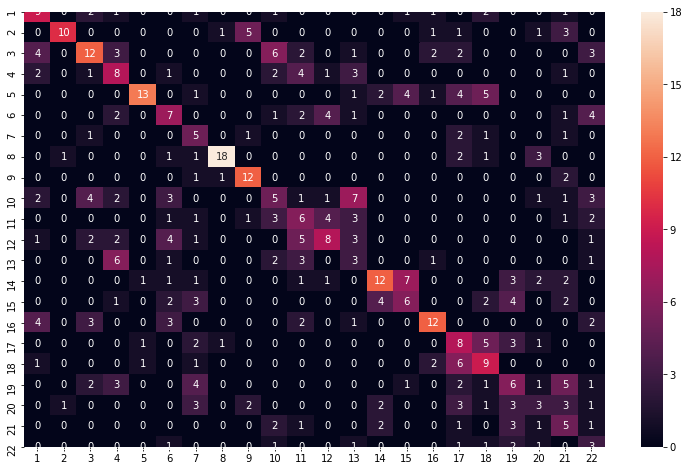

In [29]:
con = confusionmatrix(test_y+1, pred_svc_test+1, normalize = False)
import seaborn as sns
df_cm = pd.DataFrame(con, index = [i for i in range(1,23)],
                  columns = [i for i in range(1,23)])
plt.figure(figsize = (13,8))
print(sns.heatmap(df_cm, annot=True))

### Step5: Deep Learning Model

In [30]:
#CNN Conv1D using PCA
k2=0
pca= PCA(random_state = 42)
pca.fit(train_x)
total= sum(pca.explained_variance_)
current_sum=0
while current_sum/total < 0.985: #we want the reduced features explain 98.5% of the original data
    current_sum += pca.explained_variance_[k2]
    k2+=1
print(k2)

pca2=PCA(n_components=k2,whiten=True)
cnn_train_data= pca2.fit_transform(train_x)
cnn_test_data = pca2.transform(test_x)
input_shape = (k2,)

#transform y
from sklearn.model_selection import train_test_split
import tensorflow
import keras
# Convert class vectors to binary class matrices. This uses 1 hot encoding.
num_classes = 22
train_y_binary = keras.utils.to_categorical(train_y, num_classes)
test_y_binary = keras.utils.to_categorical(test_y, num_classes)
#transform x
train_x_cnn = cnn_train_data.reshape(2000, k2,1)
test_x_cnn =  cnn_test_data.reshape(500, k2,1)
#normalize x
train_x_cnn = train_x_cnn - np.mean(train_x_cnn, axis=0)
train_x_cnn = train_x_cnn/np.std(train_x_cnn, axis=0)

38


Using TensorFlow backend.


In [31]:
from datetime import datetime
#construct cnn
start=datetime.now()
from keras.models import Sequential
#from __future__ import print_function
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D,Dropout
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json
from keras import backend as K
from keras import regularizers
from keras.regularizers import l2

model = Sequential()
model.add(Conv1D(64, (3), input_shape=(k2,1), activation='relu', kernel_regularizer=l2(0.1)))
model.add(Dropout(0.2))
model.add(Conv1D(64, (3), input_shape=(k2,1), activation='relu')) #second layer
model.add(Dropout(0.2))
model.add(Conv1D(64, (3), input_shape=(k2,1), activation='relu')) #third layer
#model.add(Conv1D(64, (3), input_shape=(k2,1), activation='relu')) #fourth layer
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 36, 64)            256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 34, 64)            12352     
_________________________________________________________________
dropout_2 (Dropout)          (None, 34, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 32, 64)            12352     
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)             

In [32]:
%memit
batch_size = 200
epochs = 10
model.fit(train_x_cnn, train_y_binary,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(test_x_cnn, test_y_binary))
print('total time:',datetime.now()-start)

peak memory: 779.86 MiB, increment: 0.00 MiB
Train on 2000 samples, validate on 500 samples
Epoch 1/10
2000/2000 [==============================] - 4s 2ms/step - loss: 3.2644 - accuracy: 0.0540 - val_loss: 3.2231 - val_accuracy: 0.1100
Epoch 2/10
2000/2000 [==============================] - 1s 488us/step - loss: 3.1550 - accuracy: 0.1250 - val_loss: 3.0502 - val_accuracy: 0.1920
Epoch 3/10
2000/2000 [==============================] - 1s 505us/step - loss: 2.8901 - accuracy: 0.2065 - val_loss: 2.7033 - val_accuracy: 0.2520
Epoch 4/10
2000/2000 [==============================] - 1s 505us/step - loss: 2.5199 - accuracy: 0.2820 - val_loss: 2.5053 - val_accuracy: 0.2880
Epoch 5/10
2000/2000 [==============================] - 1s 552us/step - loss: 2.2836 - accuracy: 0.3410 - val_loss: 2.2341 - val_accuracy: 0.3400
Epoch 6/10
2000/2000 [==============================] - 1s 646us/step - loss: 2.0406 - accuracy: 0.4085 - val_loss: 2.0732 - val_accuracy: 0.3860
Epoch 7/10
2000/2000 [============